# Simulating a realistic image
In this exercise, we will simulate a realistic CCD image. There are different sources that can lead to a signal observed on a CCD camera. 

In [1]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from astropy.io import fits
plt.rcParams.update({'font.size': 16})
from mpl_toolkits.axes_grid1 import make_axes_locatable

from convenience_functions import plot_image

## **Blank image**
To start, we will construct an empty image, consisting of a two-dimensional array of zeros. The camera we will use for the simulation has the following specifications:
1) Number of active pixels: 1000 (H) $\times$ 1000 (V)
2) Read noise: 10 electrons rms
3) Dark current: 1 electrons/s/pixel
4) Full well capacity: 20,000 electrons
5) Pixel size: 4 $\mu$m (H) $\times$ 4 $\mu$m (V)

In [2]:
# Construct a blank image
blank_image = np.zeros([1000, 1000])

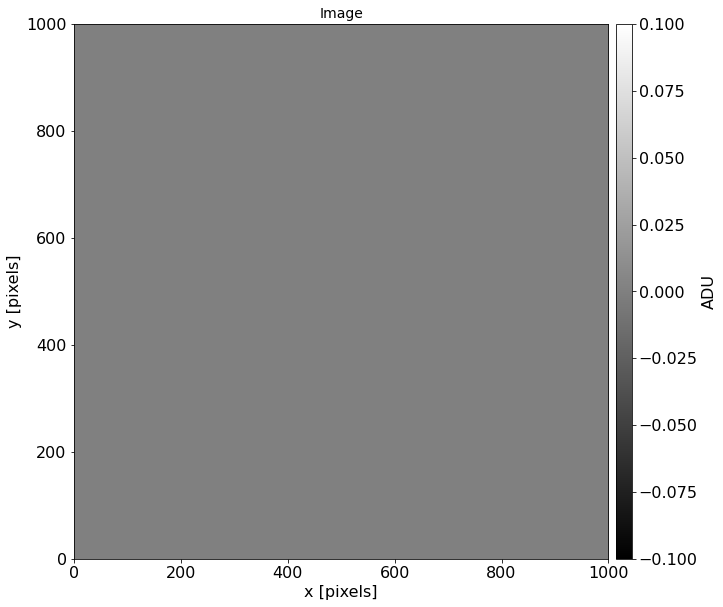

In [3]:
# plot the empty image
plot_image(image=blank_image)

## **Read noise**
Readout noise (or read noise) is the number of electrons introduced per pixel due to the readout of the device. Read noise consists of two inseparable components:
1) The conversion of an analog signal (voltage) to a digital number (ADU) is not perfectly repeatable. Each on-chip amplifier and the analog-to-digital converter (ADC) will produce a statistical distribution of values center around a mean. So, even for the case of reading the same pixel twice (each time with identical charge), a slightly different answer may be produced. 
2) The electronics themselves will introduce spurious electrons into the process, leading to random fluctuations in the output. 

Read noise is roughly Gaussian distributed, where the *standard deviation* of the distribution is the read noise. First, let's write a function to generate read noise, given the read noise specification for the camera and the gain. The gain of the camera was be calculated by the full well capacity (number of electrons one pixel can hold) and number of bits used in the digitization. For our reference camera, the full well capacity is 20,000 electrons. If the digitization resolution is 12 bits, then the gain is

\begin{equation}
K = \frac{\text{Full well capacity}}{2^{\text{bits}}-1} = \frac{20000}{2^{12}-1} \simeq \text{4.88 [$e^{-}$/ADU]}
\end{equation}

The function below will generate a different read noise array each time its run, so it operates like real read noise.

In [4]:
def get_read_noise(image,
               read_noise_std,
               gain=1):
    """
    Generate read noise 2D array.
    
    Parameters
    input:
    image: numpy array
        Science image whose shape read noise array will match
    read_noise_std: float
        Read noise of the camera [electrons rms]
    gain: float (optional)
        Gain of the camera, [electrons/ADU]
    output:
        numpy array with read noise who shape matches input science 
        array
    """
    array_shape = image.shape
    read_noise_array = np.random.normal(loc=0,
                                        scale=read_noise_std/gain,
                                        size=array_shape)
    return read_noise_array

### Exercise 1: Read noise only image
- Using the read noise generating function above (`get_read_noise`), construct an image that contains read noise only.
- In the `get_read_noise` function 
  - Provide the `blank_image` constructed above as the `image` parameter
  - Provide the read noise and gain of the reference camera using the `read_noise_std` and `gain` parameters of the function.
- Plot the read noise only image using the `plot_image` function
  - Provide the `title` parameter of the `plot_image` function to be 'Read noise only'
- Notice that the read noise corresponds to both positve and negative counts, as expected from a Gaussian distribution with zero mean.
- Does the read noise depend on the exposure time of the camera? Why or why not?

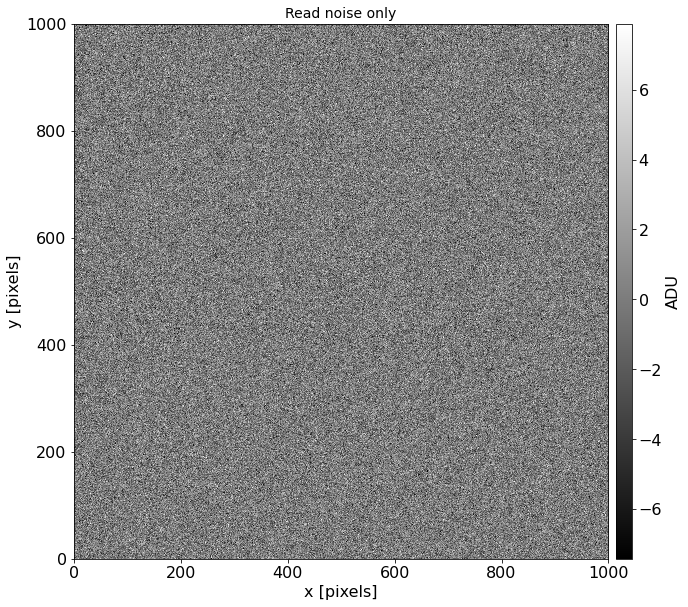

In [5]:
# Solution to Exercise 1
read_noise_img = get_read_noise(image=blank_image,
                            read_noise_std=10,
                            gain=4.88)
plot_image(image=read_noise_img, title='Read noise only')

# Read noise does not depend on exposure time, as the standard
# deviation of the conversion of an analog signal to a digital signal
# is indepedent of how long the analog signal was collected for. 
# In this case, the analog signal is the voltage across a capacitor
# which depends on the amount of charge collected by that capacitor.

## **Bias**
- To ensure the conversion from voltage to counts (ADU) always results in non-negative counts, an offset voltage (called the **bias level**) is added to each pixel. Adding a constant voltage results in adding a constant offset to the counts for each pixel, which leads to pixel values that are all positive (even for a read noise only image).
- All CCD pixels will have a bias offset, and the bias level must be removed if the data values are to be truly representative of the counts recorded per pixel. In addition, there can be small variations in the bias level across the CCD pixels, and the bias level can also vary with time and temperature. It is also common to have certain columns and pixels in which the bias level is consistently offset from the rest of the chip.
- The bad columns are typically stable over time, which allows for their correction in real data. Bias does not depend on exposure time, because a bias exposure is a zero-second exposure, where the camera simply reads out the CCD. 
- A bias frame (or bias image) is an image taken with a zero exposure time.
- Below, we create a function to generate a bias level array given the science image and the bias value to add. We also have an optional arguments to include bad columns and how many bad columns to include if so.
- Does the bias level depend on the exposure time of the camera? Why or why not?

In [6]:
def get_bias_level(image,
               bias_value,
               add_bad_columns=True,
               num_columns=5):
    """
    Generate simulated bias 2D array.
    
    Parameters
    ----------
    input: numpy array
         Science image whose shape read noise array will match
    bias_value: float
         Bias value to add to the image [ADU]
    add_bad_columns: bool, optional
         Optional argument to add bad columns to the bias image. The
         bad columns will have higher bias level than the other pixels.
    num_columns: float
         Number of bad columns to add. Default is 5.
    output:
        numpy array with the bias level with shape matches input science 
        array
    """
    bias_im = np.zeros_like(image) + bias_value
    
    if add_bad_columns:
        rng = np.random.RandomState(seed=23) 

        columns = rng.randint(0, image.shape[1], size=num_columns)
        col_value = rng.randint(0, int(0.4*bias_value), size=image.shape[0])
        
        # Add additional brightness to random columns
        for column in columns:
            bias_im[:, column] = bias_value + col_value
    return bias_im

### Exercise 2: Bias only image
- Using the `get_bias_level` function above, construct an image with only the bias.
- Set `add_bad_columns` to `True`.
- Set the `bias_level` to 200.
- Set the number of bad columns using `num_columns` to 6.
- Plot the image

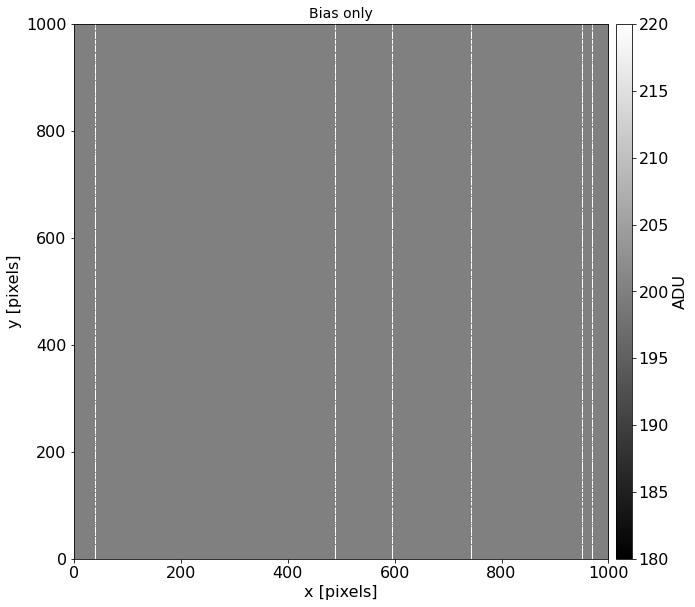

In [7]:
# Solution of Exercise 2
bias_im = get_bias_level(image=blank_image,
                     bias_value=200,
                     num_columns=6)

plot_image(image=bias_im, title="Bias only")

# The bias level does not depend on exposure time, as the bias
# level is based on a constant offset in voltage which is the same
# for different exposure times.

## Dark current
- Electrons are excited into the conduction band by incoming photons (from the astronomical source) due to the photoelectric effect. In addition to the photoelectric effect, however, it is also possible to create electron-hole pairs due to *thermal excitation* of electrons into the conduction band and will be collected within the potential well of a pixel. This is called **dark current**. 
- When the device is read out, these dark current electrons become part of the signal and are indistinguishable from electrons generated by photons from the astronomical source.
- Thermal generation of electrons in silicon is a strong function of temperature of the CCD. Therefore, CCDs for astronomical use often requires some form of cooling.
- CCDs are generally cooled with (i) liquid nitrogen, or (ii) thermoelectric cooling.
- Dark current is typically small ($<$ 1 electrons/s/pixel) and follows the Poisson distribution.
- For a small fraction of pixels, the dark current value is much greater than the rest of the pixels. Such pixels are called *hot pixels*. The dark current in hot pixels is stable over time, allowing for their subtraction in image cleaning. 
- Below, we write a function to simulate dark current that can be added to an image.

In [8]:
def get_dark_current(image, 
                dark_current,
                exposure_time,
                gain=1.0,
                hot_pixels=False,
                hot_pixels_percentage=0.01):
    dark_adu = dark_current * exposure_time / gain
    dark_im = np.random.poisson(lam=dark_adu, size=image.shape)
    
    if hot_pixels:
        y_max, x_max = dark_im.shape
        n_hot = int((hot_pixels_percentage/100) * x_max * y_max)
        
        rng = np.random.RandomState(100)
        hot_x = rng.randint(0, x_max, size=n_hot)
        hot_y = rng.randint(0, y_max, size=n_hot)
        
        hot_current = 1000 * dark_current
        
        for i in range(len(hot_x)):
            dark_im[hot_x[i], hot_y[i]] = (hot_current  
                                           * exposure_time / gain)
    return dark_im

### Exercise 3: Dark current only image
- Using the `get_dark_current` function above, construct a dark current only image.
- Take the `dark_current` to be 1 electron per second per pixel. 
- Take the `exposure_time` to be 100 seconds.
- Plot the dark current only image
- Turn on and off `hot_pixels` to see their effect on the image.
- Change the `exposure_time` to smaller and larger values to see the affect of exposure time on dark current.
- Does dark current increase or decrease with exposure time? Why?

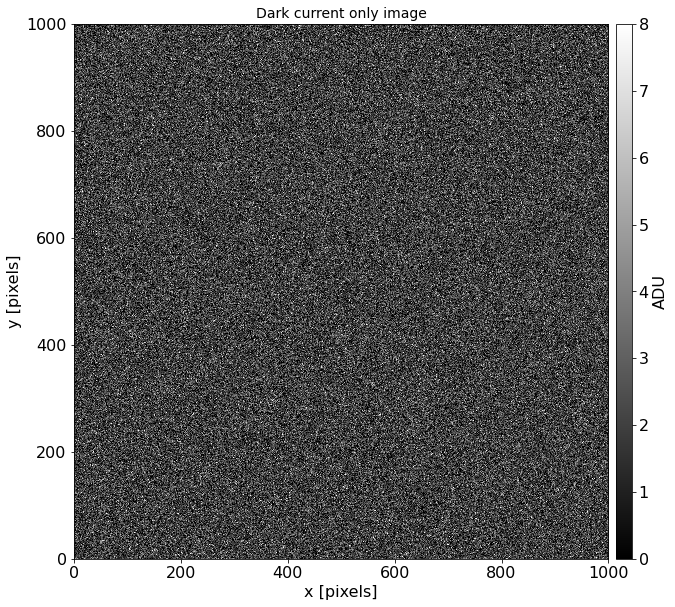

In [9]:
# Solution to Exercise 3
exposure_time = 100
dark_cur = 0.1
dark_im = get_dark_current(image=blank_image,
                           dark_current=dark_cur,
                           gain=4.88,
                           exposure_time=exposure_time,
                           hot_pixels=False)

plot_image(dark_im, title='Dark current only image')

# Dark current increases linearly with exposure time because more 
# thermally generated electrons are excited into the conduction band 
# for a longer exposure.

## Sky background
The sky itself can add signal to the CCD image. There are various source of sky background:
1) *Zodiacal light*
- Caused by sunlight scattered from the diffuse cloud of interplanetary dust particles that lies primarily in the plane of the solar system.
- Function of the viewing direction, wavelength, heliocentric distance, and the position
of the observer relative to the symmetry plane of interplanetary dust.

2) *Airglow*
- Caused by the chemiluminescence of upper
atmosphere atoms and molecules
- Function of zenith angle, local time, geographic latitude, season, solar activity, and
altitude. 

3) Integrated starlight
- Due to the combined light from unresolved stars in the Milky Way.
- Depends on the ability for the telescope to resolve stars, which is set by its limiting magnitude. 

4) Diffuse Galactic light
- Due to the diffuse component of the Galactic background radiation produced by scattering of starlight by interstellar dust. 

5) Extragalactic background light
- Due to redshifted starlight from unresolved galaxies, stars or gas
in intergalactic space, or redshifted emission from dust
particles heated by starlight in galaxies can also contribute to the total sky background.

Sky background noise is Poisson distributed. 

### Exercise 4: Sky background noise generation function
- Using the `get_dark_current` function as a reference, write a function called `get_sky_bkg` that will generate add sky noise to an image. 
- The sky background level increases with exposure time, just like the dark current does.
- The input parameters of the function should be:
    - `image`: (numpy array) image whose shape the sky noise image will match 
    - `sky_noise_electrons`: (float) sky noise level in [electrons per second per pixel]
    - `exposure_time`: (float) exposure time of the image [seconds]
    - `gain`: (float) gain of the camera [electron / ADU]
- The function should return a numpy array that has the sky background added to it.
- Using the function, plot a sky background only image for:
    - `sky_noise_electrons` = 0.2 electrons per second per pixel
    - `exposure_time` = 100 seconds

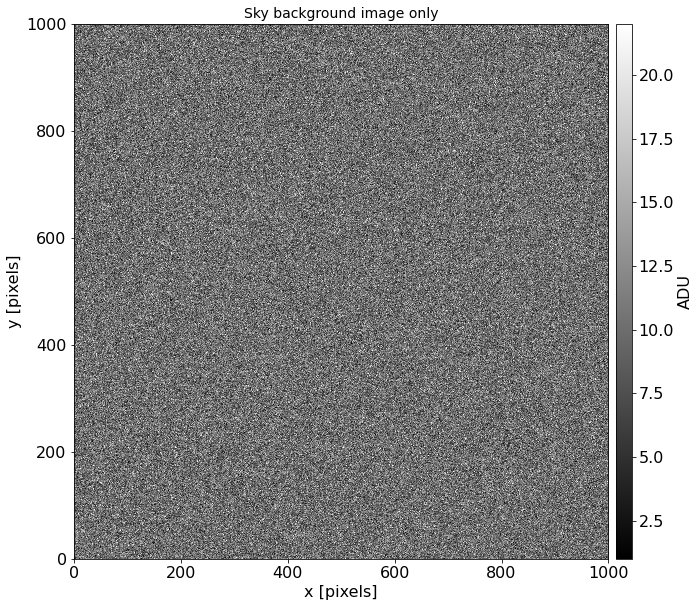

In [10]:
def get_sky_bkg(image, 
                sky_noise_electrons,
                exposure_time,
                gain=1.0):    
    sky_adu = sky_noise_electrons * exposure_time / gain
    sky_im = np.random.poisson(lam=sky_adu, size=image.shape)
    return sky_im

sky_bkg_im = get_sky_bkg(image=blank_image,
                             sky_noise_electrons=0.5,
                             gain=4.88,
                             exposure_time=100)

plot_image(image=sky_bkg_im,
           title='Sky background image only')

### Exercise 5: Combined noise image
- Now, construct an image that contains all the noise components discussed above.
    - The image should include read noise, dark current, sky noise, and the bias image.
    - Choose an exposure time of 100 seconds.
    - Choose the dark current to be 0.1 electrons per second per pixel. For simplicity, do not add hot pixels to the image.
    - Choose the sky noise level to be 0.5 electrons per second per pixel. 
    - Choose the bias level to be 200 ADU and include 6 bad columns.
    - Choose the read noise to be 10 electrons RMS.
    - Choose the camera gain to be 4.88 electrons per ADU.

- Plot the combined noise image. Run the cell multiple times. Each iteration will generate a slightly different noise image.

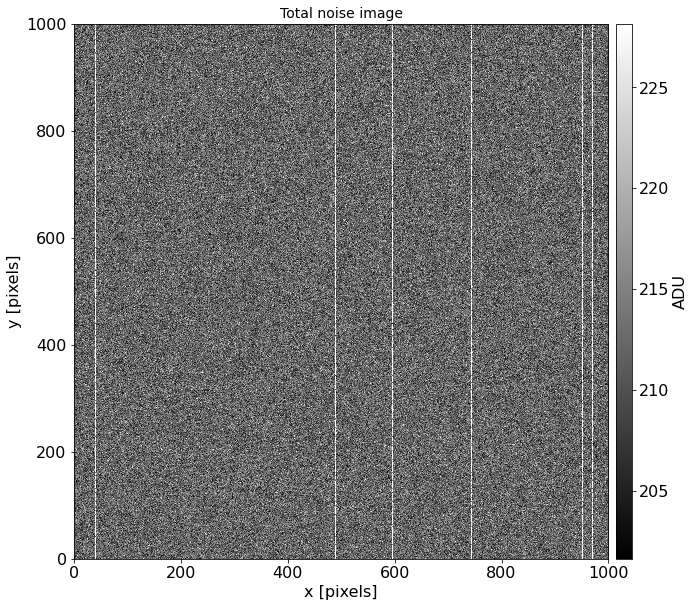

In [11]:
# Solution to Exercise 5
im_read_noise = get_read_noise(image=blank_image,
                               read_noise_std=10,
                               gain=4.88)
im_dark_current = get_dark_current(image=blank_image,
                           dark_current=0.1,
                           gain=4.88,
                           exposure_time=100,
                           hot_pixels=False)
im_sky_noise = get_sky_bkg(image=blank_image,
                             sky_noise_electrons=0.5,
                             gain=4.88,
                             exposure_time=100)
im_bias = get_bias_level(image=blank_image,
                     bias_value=200,
                     num_columns=6)

noise_combined = im_read_noise+im_dark_current+im_sky_noise+im_bias
plot_image(image=noise_combined,
           title='Total noise image')

## Noise image (interactive)
- Now, we will create a function `noise_image_int` that can interactively display the noise image for varying noise parameters.


In [12]:
from ipywidgets import interactive

def noise_image_int(bias_value=200,
                   read_noise_std=10,
                   gain=4.88,
                   dark_current=0.1,
                   hot_pixels_percentage=0.01,
                   sky_noise_electrons=0.5,
                   exposure=100,
                   hot_pixels=False,
                   num_columns=6):
    
    # Construct a blank image
    blank_image = np.zeros([1000, 1000])
    
    # Construct a read noise only image
    im_read_noise = get_read_noise(image=blank_image,
                                   read_noise_std=read_noise_std,
                                   gain=gain)
    
    # Construct a dark current only image
    im_dark_current = get_dark_current(image=blank_image,
                               dark_current=dark_current,
                               gain=gain,
                               exposure_time=exposure_time,
                               hot_pixels=False)
    
    # Construct a sky noise only image
    im_sky_noise = get_sky_bkg(image=blank_image,
                                 sky_noise_electrons=sky_noise_electrons,
                                 gain=gain,
                                 exposure_time=exposure_time)
    
    # Construct a bias only image
    im_bias = get_bias_level(image=blank_image,
                         bias_value=bias_value,
                         num_columns=num_columns)

    noise = im_read_noise+im_dark_current+im_sky_noise+im_bias
    
    # plot
    plot_image(image=noise, title="Noise image")
    
demo = interactive(noise_image_int, 
                bias_value=(10,500,10), 
                dark_current=(0.0,1,0.1),
                hot_pixels_percentage=(0, 1, 0.01),
                sky_noise_electrons=(0.01, 2.01, 0.01),
                gain=(0.5, 10, 0.25), 
                read=(0, 50, 5),
                num_columns=(0, 100, 1),
                exposure=(0, 500, 20))

for kid in demo.children:
    try:
        kid.continuous_update = True
    except KeyError:
        pass

### Exercise 6: Interactive noise image. 
- In a new cell, write `demo`. This should lead to an interactive noise image.
- Change the various parameter values by sliding the slider to see their effect on the total noise image.

In [13]:
# Solution to Exercise 6.
demo

interactive(children=(IntSlider(value=200, description='bias_value', max=500, min=10, step=10), IntSlider(valu…